# Capstone project

## Introduction / Business problem

Stakeholders of a new restaurant that will be opening in São Paulo, Brazil, are willing to take data-driven decision on where and what type and level of restaurant to open in the city.  
They want to know where the best place is and why. Furthermore, they want to know the best price range of the restaurant given the location it will be - if it is in a more humble neighborhood, it will have lower prices. On the other hand, if it is a fancy or elite neighborhood, it will have higher prices.

## What data will be used to solve the problem

To achieve the goal, two data sources will be used:  
- Subway survey  
    - An extensive survey had been carried out by São Paulo's subway in 2017  
    - It has a lot of information about the city population, such as income, trips, from where to where and many other
    - It includes the coordinates of each neighborhood, and in each one many surveys were carried out
    - For this project, we will be using the 'centroid' of each zone with its average income, previously calculated
- Foursquare data
    - We will be using the centroids of each zone together with foursquare data
    - We will acquire data from foursquare database to each zone, such as number and types of restaurants and also other types of establishments, also relevant to our analysis

## Data Gathering

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
from pandas.io.json import json_normalize

In [2]:
CLIENT_ID = 'MEX3ZDSCXQDQGZ0LOXAPON2BMN0GUI4GDBDAFJDT4SA5NDUN' # your Foursquare ID
CLIENT_SECRET = '5WXEIPK4ZNTU1KTZ4CKKGYZNG20ZFOQZRHLEV1GO1QEBONVA' # your Foursquare Secret
VERSION = '20191010'
radius = 1000
LIMIT = 500

In [51]:
df_zones = pd.read_csv(r'C:\Users\Lucca\OneDrive\BACKUP\CURSOS\IBM Data Science\Capstone\ZoneCoords.csv',sep=';')
df_zones.sort_values(by='ZONE_NAME',inplace=True)
df_zones.rename(columns={'ZONE_NAME':'Neighborhood','AVG INCOME':'AvgIncome'},inplace=True)
print(df_zones.shape)
df_zones.head()

(492, 4)


,Neighborhood,ZONE_LON,ZONE_LAT,AvgIncome
20,Aclimação,-46.632651,-23.572122,6634.187271
301,Adventista,-46.782144,-23.674832,3421.176299
336,Afonso Moreno,-46.751001,-23.285508,2907.211722
462,Aldeia de Carapicuíba,-46.823648,-23.573091,5877.097174
129,Alfredo Pujol,-46.629673,-23.496992,8227.907394


In [30]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name,i)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
sp_venues = getNearbyVenues(names=df_zones['ZONE_NAME'],
                                   latitudes=df_zones['ZONE_LAT'],
                                   longitudes=df_zones['ZONE_LON'])

# Clustering similar neighborhoods

**We will now cluster the similar neighborhoods in 5 clusters**

In [33]:
# unique categories
print('There are {} unique categories.'.format(len(sp_venues['Venue Category'].unique())))

There are 462 unique categories.


In [34]:
# one hot encoding
sp_onehot = pd.get_dummies(sp_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sp_onehot['Neighborhood'] = sp_venues['Neighborhood'] 

print(sp_onehot.shape)

sp_grouped = sp_onehot.groupby('Neighborhood').sum().reset_index()
sp_grouped.head()

(26050, 462)


,Neighborhood,ATM,Acai House,Accessories Store,Adult Boutique,Advertising Agency,African Restaurant,Airport,Airport Lounge,Airport Service,...,Water Park,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Aclimação,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,Adventista,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,Afonso Moreno,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Aldeia de Carapicuíba,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Alfredo Pujol,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [36]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        #columns.append('{}{} Most Common Venue Qty'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        #columns.append('{}th Most Common Venue Qty'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = sp_grouped['Neighborhood']

for ind in np.arange(sp_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sp_grouped.iloc[ind, :], num_top_venues)

print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

(486, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aclimação,Gym / Fitness Center,Pizza Place,Bakery,Pet Store,Farmers Market,Bar,Restaurant,BBQ Joint,Hostel,Coffee Shop
1,Adventista,Bakery,Brazilian Restaurant,Grocery Store,Gym / Fitness Center,Pizza Place,Convenience Store,Pharmacy,Food Truck,Department Store,Breakfast Spot
2,Afonso Moreno,Gym,Pizza Place,Bar,Brazilian Restaurant,Italian Restaurant,Dance Studio,Dessert Shop,Juice Bar,Pharmacy,Pet Store
3,Aldeia de Carapicuíba,Pet Store,Bakery,Brazilian Restaurant,Burger Joint,Health & Beauty Service,Bus Stop,Restaurant,Video Store,Pizza Place,Gym / Fitness Center
4,Alfredo Pujol,Pizza Place,Burger Joint,Japanese Restaurant,Middle Eastern Restaurant,Dessert Shop,Restaurant,Pharmacy,Gym / Fitness Center,Italian Restaurant,Sushi Restaurant


In [38]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 5

sp_grouped_clustering = sp_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sp_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print(kmeans.labels_.shape)
kmeans.labels_[0:10]

(486,)


array([4, 2, 3, 3, 4, 4, 4, 2, 4, 3])

In [53]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

sp_merged = df_zones

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
sp_merged = sp_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

print(sp_merged.shape)
sp_merged.head() # check the last columns!

(492, 15)


,Neighborhood,ZONE_LON,ZONE_LAT,AvgIncome,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Aclimação,-46.632651,-23.572122,6634.187271,4.0,Gym / Fitness Center,Pizza Place,Bakery,Pet Store,Farmers Market,Bar,Restaurant,BBQ Joint,Hostel,Coffee Shop
301,Adventista,-46.782144,-23.674832,3421.176299,2.0,Bakery,Brazilian Restaurant,Grocery Store,Gym / Fitness Center,Pizza Place,Convenience Store,Pharmacy,Food Truck,Department Store,Breakfast Spot
336,Afonso Moreno,-46.751001,-23.285508,2907.211722,3.0,Gym,Pizza Place,Bar,Brazilian Restaurant,Italian Restaurant,Dance Studio,Dessert Shop,Juice Bar,Pharmacy,Pet Store
462,Aldeia de Carapicuíba,-46.823648,-23.573091,5877.097174,3.0,Pet Store,Bakery,Brazilian Restaurant,Burger Joint,Health & Beauty Service,Bus Stop,Restaurant,Video Store,Pizza Place,Gym / Fitness Center
129,Alfredo Pujol,-46.629673,-23.496992,8227.907394,4.0,Pizza Place,Burger Joint,Japanese Restaurant,Middle Eastern Restaurant,Dessert Shop,Restaurant,Pharmacy,Gym / Fitness Center,Italian Restaurant,Sushi Restaurant


**We know have similar neighborhoods clustered in 5 clusters**

# Neighborhood: Food Analysis

**We will now repeat the process, but only establishments in the food category**

In [75]:
def getNearbyVenuesFood(names, latitudes, longitudes, radius=1000):

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name,i)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4d4b7105d754a06374d81259'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [77]:
sp_venues_food = getNearbyVenuesFood(names=df_zones['Neighborhood'],
                                   latitudes=df_zones['ZONE_LAT'],
                                   longitudes=df_zones['ZONE_LON'])

In [78]:
# one hot encoding
sp_onehot_food = pd.get_dummies(sp_venues_food[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sp_onehot_food['Neighborhood'] = sp_venues_food['Neighborhood'] 

print(sp_onehot_food.shape)

sp_grouped_food = sp_onehot_food.groupby('Neighborhood').sum().reset_index()
sp_grouped_food.head()

(21789, 125)


,Neighborhood,Acai House,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,...,Tapas Restaurant,Tapiocaria,Thai Restaurant,Theme Restaurant,Trattoria/Osteria,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Aclimação,1,0,0,0,0,0,0,0,10,...,0,0,1,0,0,0,0,1,0,0
1,Adventista,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Afonso Moreno,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
3,Aldeia de Carapicuíba,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Alfredo Pujol,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,2,0,0


In [79]:
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        #columns.append('{}{} Most Common Venue Qty'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        #columns.append('{}th Most Common Venue Qty'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_food = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_food['Neighborhood'] = sp_grouped_food['Neighborhood']

for ind in np.arange(sp_grouped_food.shape[0]):
    neighborhoods_venues_sorted_food.iloc[ind, 1:] = return_most_common_venues(sp_grouped_food.iloc[ind, :], num_top_venues)

print(neighborhoods_venues_sorted_food.shape)
neighborhoods_venues_sorted_food.head()

(475, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aclimação,Bakery,Pizza Place,Restaurant,BBQ Joint,Brazilian Restaurant,Chinese Restaurant,Korean Restaurant,Café,Snack Place,Sushi Restaurant
1,Adventista,Bakery,Brazilian Restaurant,Pizza Place,Diner,Restaurant,Food Truck,Snack Place,Fast Food Restaurant,Breakfast Spot,Burger Joint
2,Afonso Moreno,Brazilian Restaurant,Pizza Place,BBQ Joint,Italian Restaurant,Japanese Restaurant,Restaurant,Fast Food Restaurant,Fried Chicken Joint,Snack Place,Diner
3,Aldeia de Carapicuíba,Bakery,Pizza Place,Restaurant,Diner,Burger Joint,Brazilian Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empada House,Fish Taverna
4,Alfredo Pujol,Restaurant,Pizza Place,Brazilian Restaurant,Japanese Restaurant,Burger Joint,Bakery,Middle Eastern Restaurant,Sushi Restaurant,Café,Italian Restaurant


# Comparing similar neighborhoods with opportunities to new food businesses

**We will now consider that the previous clustering allows us to identify neighborhoods where there are opportunities of opening a new food business based on neighborhoods on the same clusters but with different common food vanues**

In [94]:
df_merged = sp_merged.drop(columns=['ZONE_LON', 'ZONE_LAT','1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'])

In [95]:
df_merged = pd.merge(df_merged,neighborhoods_venues_sorted_food,on='Neighborhood')
df_merged.sort_values(by='Cluster Labels',ascending=True,inplace=True)
df_merged.dropna(subset=['Cluster Labels'],inplace=True)
print(df_merged.shape)
df_merged.head()

(474, 13)


,Neighborhood,AvgIncome,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
295,Parque São Jorge,6624.533668,0.0,Pizza Place,Bakery,Brazilian Restaurant,Restaurant,Diner,Café,Japanese Restaurant,Burger Joint,Indian Sweet Shop,Middle Eastern Restaurant
37,Bom Jardim,4102.030717,0.0,Brazilian Restaurant,Bakery,Restaurant,Middle Eastern Restaurant,Churrascaria,Snack Place,Café,Pizza Place,BBQ Joint,South American Restaurant
38,Bom Retiro,3815.819611,0.0,Brazilian Restaurant,Restaurant,Café,Bakery,Diner,Pizza Place,Fast Food Restaurant,Snack Place,Korean Restaurant,Buffet
42,Bresser,3306.084391,0.0,Brazilian Restaurant,Café,Snack Place,Diner,Fast Food Restaurant,Food Truck,Restaurant,Burger Joint,Japanese Restaurant,Bakery
44,Brás,3313.709285,0.0,Brazilian Restaurant,Restaurant,Italian Restaurant,Food Truck,Fast Food Restaurant,Café,Snack Place,Bakery,Diner,Pizza Place


In [152]:
cluster0 = df_merged[df_merged['Cluster Labels']==0]
cluster1 = df_merged[df_merged['Cluster Labels']==1]
cluster2 = df_merged[df_merged['Cluster Labels']==2]
cluster3 = df_merged[df_merged['Cluster Labels']==3]
cluster4 = df_merged[df_merged['Cluster Labels']==4]

In [153]:
cluster0 = cluster0.iloc[:,3:13].to_numpy()
venues,count = np.unique(cluster0,return_counts=True)
dfcl0 = pd.DataFrame()
dfcl0['Venues'] = venues
dfcl0['Count'] = count
dfcl0.set_index('Venues',inplace=True)
dfcl0.sort_values(by='Count',inplace=True,ascending=False)

cluster1 = cluster1.iloc[:,3:13].to_numpy()
venues,count = np.unique(cluster1,return_counts=True)
dfcl1 = pd.DataFrame()
dfcl1['Venues'] = venues
dfcl1['Count'] = count
dfcl1.set_index('Venues',inplace=True)
dfcl1.sort_values(by='Count',inplace=True,ascending=False)

cluster2 = cluster2.iloc[:,3:13].to_numpy()
venues,count = np.unique(cluster2,return_counts=True)
dfcl2 = pd.DataFrame()
dfcl2['Venues'] = venues
dfcl2['Count'] = count
dfcl2.set_index('Venues',inplace=True)
dfcl2.sort_values(by='Count',inplace=True,ascending=False)

cluster3 = cluster3.iloc[:,3:13].to_numpy()
venues,count = np.unique(cluster3,return_counts=True)
dfcl3 = pd.DataFrame()
dfcl3['Venues'] = venues
dfcl3['Count'] = count
dfcl3.set_index('Venues',inplace=True)
dfcl3.sort_values(by='Count',inplace=True,ascending=False)

cluster4 = cluster4.iloc[:,3:13].to_numpy()
venues,count = np.unique(cluster4,return_counts=True)
dfcl4 = pd.DataFrame()
dfcl4['Venues'] = venues
dfcl4['Count'] = count
dfcl4.set_index('Venues',inplace=True)
dfcl4.sort_values(by='Count',inplace=True,ascending=False)

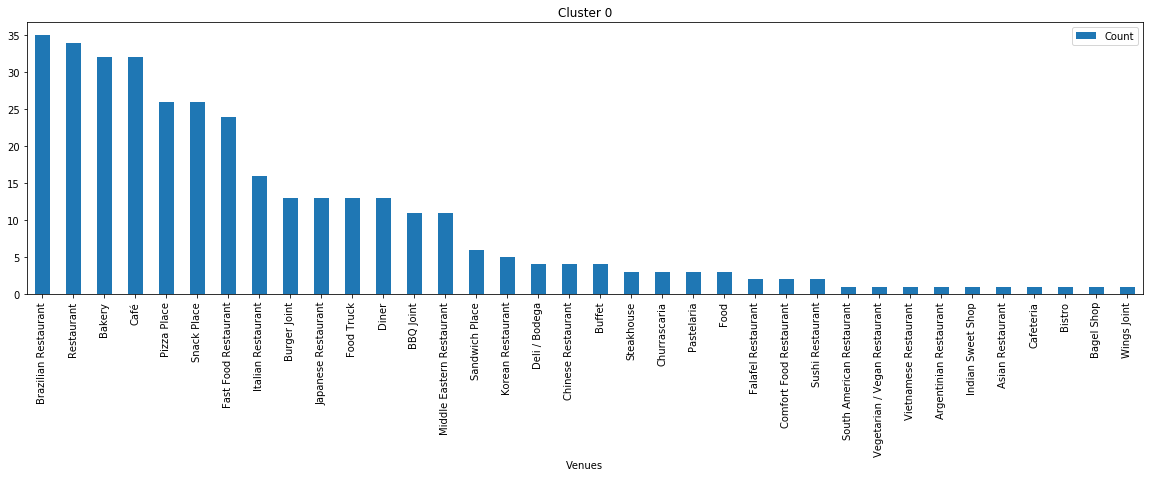

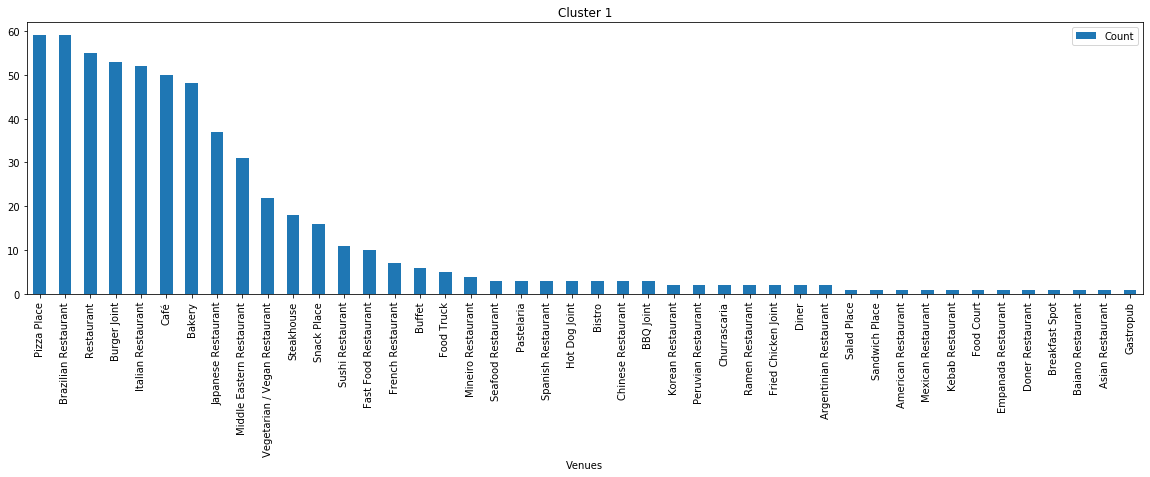

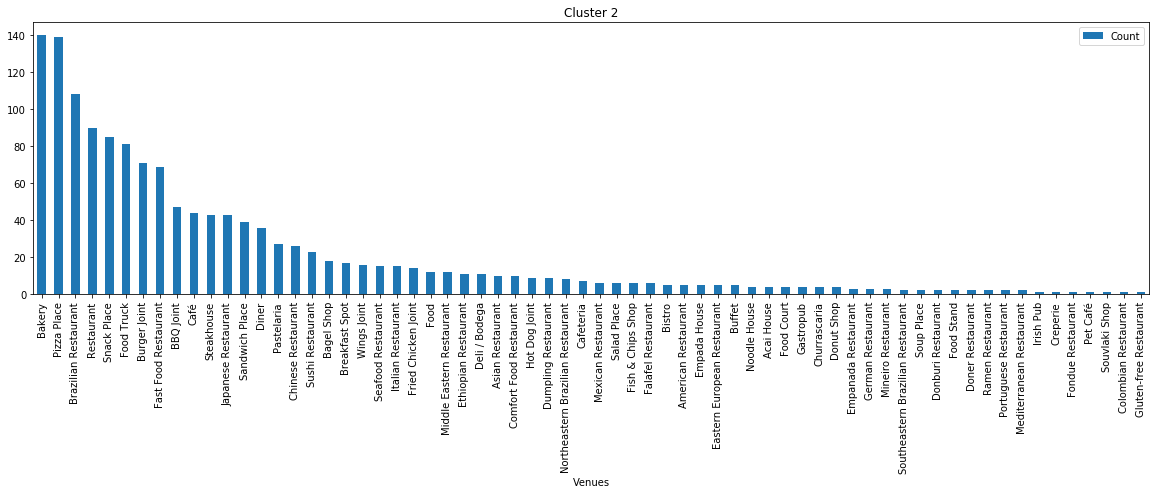

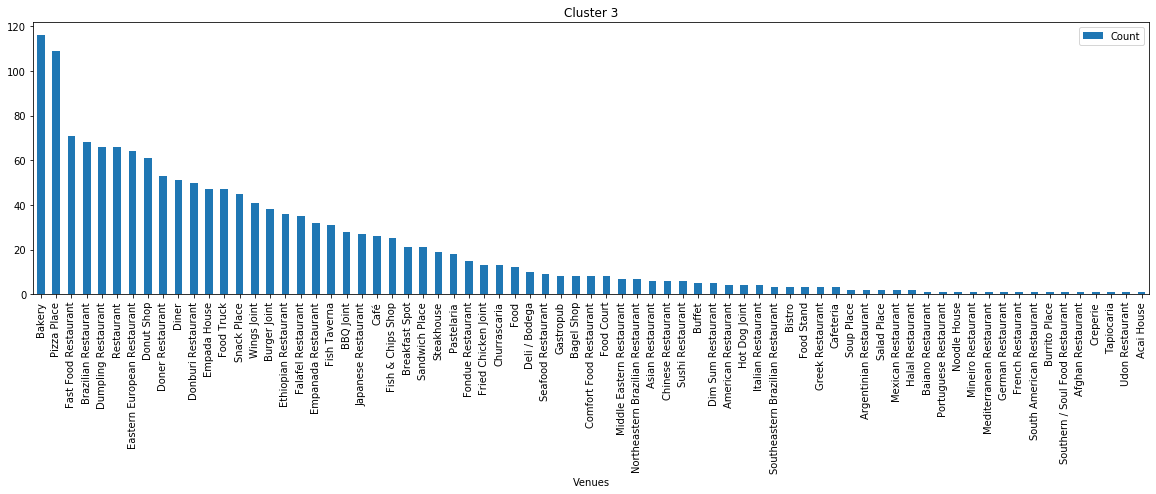

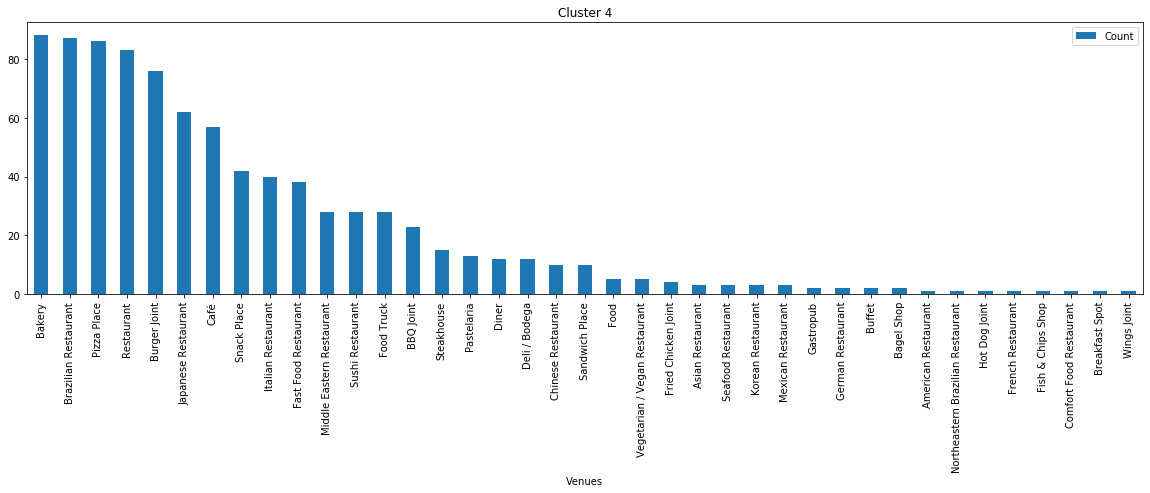

In [176]:
dfcl0.plot(kind='bar',figsize=(20,5),title='Cluster 0')
dfcl1.plot(kind='bar',figsize=(20,5),title='Cluster 1')
dfcl2.plot(kind='bar',figsize=(20,5),title='Cluster 2')
dfcl3.plot(kind='bar',figsize=(20,5),title='Cluster 3')
dfcl4.plot(kind='bar',figsize=(20,5),title='Cluster 4')

**We can see some opportunities, can't we?  
For example, in a neighborhood in cluster 0, a wings joint or bagel shop are good options  
A brazilian restaurant however can be too much competition**

# Choosing based on Income

**We will now use Income to cherry pick some neighborhood with high average income so our prices can be higher  
Let's see the highest income for each cluster**

In [201]:
df_merged['AvgIncome'] = df_merged['AvgIncome'].astype(int)
df_merged['Cluster Labels'] = df_merged['Cluster Labels'].astype(int)
df_merged[df_merged['Cluster Labels']==0].sort_values(by='AvgIncome',ascending=False).set_index('Neighborhood').head(1)

,AvgIncome,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,,
Butantã,11909,0,Restaurant,Brazilian Restaurant,Pizza Place,Food Truck,Bakery,Burger Joint,Café,Buffet,Fast Food Restaurant,Diner


In [202]:
sp_grouped_food[sp_grouped_food['Neighborhood']=='Butantã'][['Neighborhood','Wings Joint','Bagel Shop']].set_index('Neighborhood')

,Wings Joint,Bagel Shop
Neighborhood,,
Butantã,0,0


**This is great! There are no bagel shops or wings joints on Butantã. Those are opportunities, since similar neighborhoods likes these two venues!**

In [188]:
df_merged['AvgIncome'] = df_merged['AvgIncome'].astype(int)
df_merged['Cluster Labels'] = df_merged['Cluster Labels'].astype(int)
df_merged[df_merged['Cluster Labels']==1].sort_values(by='AvgIncome',ascending=False).head(5)

,Neighborhood,AvgIncome,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
112,FAAP,15917,1,Pizza Place,Italian Restaurant,Bakery,Brazilian Restaurant,Restaurant,French Restaurant,Café,Japanese Restaurant,Burger Joint,Middle Eastern Restaurant
216,Jardins,13809,1,Italian Restaurant,Restaurant,Brazilian Restaurant,Middle Eastern Restaurant,Bakery,Pizza Place,Burger Joint,Café,Japanese Restaurant,Spanish Restaurant
264,Pacaembu,13437,1,Restaurant,Brazilian Restaurant,Café,Bakery,Burger Joint,Italian Restaurant,Vegetarian / Vegan Restaurant,Pizza Place,Argentinian Restaurant,Japanese Restaurant
172,Jardim Europa,13432,1,Italian Restaurant,Restaurant,Japanese Restaurant,Pizza Place,French Restaurant,Middle Eastern Restaurant,Brazilian Restaurant,Bakery,Café,Sushi Restaurant
316,Pompéia,13153,1,Pizza Place,Brazilian Restaurant,Burger Joint,Bakery,Restaurant,Middle Eastern Restaurant,Italian Restaurant,Pastelaria,Café,BBQ Joint


In [189]:
sp_grouped_food[sp_grouped_food['Neighborhood']=='FAAP'][['Neighborhood','Gastropub','Asian Restaurant']]

,Neighborhood,Gastropub,Asian Restaurant
112,FAAP,0,0


**A Gastropub or Asian restaurant are also options on FAAP**

In [190]:
df_merged['AvgIncome'] = df_merged['AvgIncome'].astype(int)
df_merged['Cluster Labels'] = df_merged['Cluster Labels'].astype(int)
df_merged[df_merged['Cluster Labels']==2].sort_values(by='AvgIncome',ascending=False).head(5)

,Neighborhood,AvgIncome,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Alto de Pinheiros,15037,2,Restaurant,Fast Food Restaurant,Diner,Snack Place,Bakery,BBQ Joint,Café,Brazilian Restaurant,Food Truck,Mediterranean Restaurant
36,Boaçava,9995,2,Bakery,Pizza Place,Sushi Restaurant,Brazilian Restaurant,Restaurant,Japanese Restaurant,Food Truck,Snack Place,Pastelaria,Burger Joint
252,Morumbi,9278,2,Pizza Place,Brazilian Restaurant,Bakery,Restaurant,Japanese Restaurant,BBQ Joint,Churrascaria,Burger Joint,Snack Place,Fast Food Restaurant
315,Planalto Paulista,8556,2,Restaurant,Pizza Place,Brazilian Restaurant,Sandwich Place,Café,Bakery,Snack Place,Bagel Shop,Food Truck,Wings Joint
398,Tucuruvi,8441,2,Bakery,Pizza Place,Burger Joint,Japanese Restaurant,Mexican Restaurant,Fast Food Restaurant,Food Truck,BBQ Joint,Brazilian Restaurant,Italian Restaurant


In [192]:
sp_grouped_food[sp_grouped_food['Neighborhood']=='Alto de Pinheiros'][['Neighborhood','Irish Pub','Fondue Restaurant']]

,Neighborhood,Irish Pub,Fondue Restaurant
7,Alto de Pinheiros,0,0


**An Irish Pub or Fondue restaurant are also options on Alto de Pinheiros**

In [195]:
df_merged['AvgIncome'] = df_merged['AvgIncome'].astype(int)
df_merged['Cluster Labels'] = df_merged['Cluster Labels'].astype(int)
df_merged[df_merged['Cluster Labels']==3].sort_values(by='AvgIncome',ascending=False).head(5)

,Neighborhood,AvgIncome,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
225,Jóquei Clube,16035,3,Restaurant,BBQ Joint,Bakery,Burger Joint,Food Court,Fast Food Restaurant,Café,Breakfast Spot,Empanada Restaurant,Fish Taverna
328,Real Parque,11332,3,Café,Restaurant,Snack Place,Bagel Shop,Middle Eastern Restaurant,Diner,American Restaurant,Dumpling Restaurant,Fast Food Restaurant,Japanese Restaurant
337,Ribeirão das Pombas,10821,3,Pizza Place,Café,Brazilian Restaurant,Steakhouse,Restaurant,Fried Chicken Joint,BBQ Joint,Burger Joint,Bistro,Bakery
74,Chácara Flora,10809,3,Food Truck,Fast Food Restaurant,Fish & Chips Shop,Restaurant,Pastelaria,Snack Place,Food,Pizza Place,Fried Chicken Joint,Empada House
14,Aphaville,8531,3,Restaurant,Cafeteria,Food,Wings Joint,Fish & Chips Shop,Diner,Donburi Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant


In [196]:
sp_grouped_food[sp_grouped_food['Neighborhood']=='Jóquei Clube'][['Neighborhood','Acai House','Tapiocaria']]

,Neighborhood,Acai House,Tapiocaria
225,Jóquei Clube,0,0


**Or maybe an açai house or tapiocaria on Jóquei Clube**

In [198]:
df_merged['AvgIncome'] = df_merged['AvgIncome'].astype(int)
df_merged['Cluster Labels'] = df_merged['Cluster Labels'].astype(int)
df_merged[df_merged['Cluster Labels']==4].sort_values(by='AvgIncome',ascending=False).head(5)

,Neighborhood,AvgIncome,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
207,Jardim Vitória Régia,12996,4,Pizza Place,Japanese Restaurant,Italian Restaurant,Bakery,Café,Steakhouse,Fast Food Restaurant,Brazilian Restaurant,Restaurant,Burger Joint
438,Vila Mariana,12627,4,Pizza Place,Brazilian Restaurant,Bakery,Restaurant,Burger Joint,Café,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Snack Place,Sushi Restaurant
66,Cardoso de Almeida,11843,4,Bakery,Pizza Place,Sushi Restaurant,Burger Joint,Vegetarian / Vegan Restaurant,Food Truck,Italian Restaurant,Brazilian Restaurant,Restaurant,Japanese Restaurant
263,PUC,11668,4,Bakery,Pizza Place,Brazilian Restaurant,Burger Joint,Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Middle Eastern Restaurant,Food Truck
434,Vila Leopoldina,10535,4,Brazilian Restaurant,Pizza Place,Japanese Restaurant,Bakery,Restaurant,Burger Joint,Italian Restaurant,Sushi Restaurant,Middle Eastern Restaurant,BBQ Joint


In [199]:
sp_grouped_food[sp_grouped_food['Neighborhood']=='Jardim Vitória Régia'][['Neighborhood','Wings Joint','Fish & Chips Shop']]

,Neighborhood,Wings Joint,Fish & Chips Shop
207,Jardim Vitória Régia,0,0


**Or maybe a wings joint or Fish & Chips Shop on Jardim Vitória Régia**